In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import json
import h5py

In [4]:
data = {}
batchNames = ['v6_batch0','v6_batch4']
paramsNameList = ['Spontaneous','S1_Thalamus']

for labelNumber,batchName in enumerate(batchNames):

    paramsName = paramsNameList[labelNumber]
    data[paramsName] = {}
    
    hf = h5py.File(batchName+'/RasterPlot.h5', 'r')
    spkid = np.array(hf.get('spkid'))
    spkt = np.array(hf.get('spkt'))
    hf.close()

    hf = h5py.File(batchName+'/Voltage_soma.h5', 'r') 
    
    cellVNumber = []
    data[paramsName]['V_soma'] = {}    
    
    cellVNumber = []
    for cellName in list(hf.keys()):
        cellVNumber.append(int(cellName.split('_')[1]))
    cellVNumber = np.sort(cellVNumber)   
    
    for cellName in cellVNumber:
        Vt = np.array(hf.get('cell_'+str(cellName)))
        data[paramsName]['V_soma']['cell_'+str(cellName)] = Vt
        
    hf.close()
    
    data[paramsName]['spkid'] = spkid
    data[paramsName]['spkt'] = spkt

In [5]:
# S1 Cells
# Load 55 Morphological Names and Cell pop numbers -> L1:6 L23:10 L4:12 L5:13 L6:14
# Load 207 Morpho-electrical Names used to import the cells from 'cell_data/' -> L1:14 L23:43 L4:46 L5:52 L6:52
# Create [Morphological,Electrical] = number of cell metype in the sub-pop

with open('../../info/anatomy/S1-cells-distributions-Rat.txt') as mtype_file:
    mtype_content = mtype_file.read()       

popNumber = {}
cellNumber = {} 
popLabel = {} 
popParam = []
cellParam = []
meParamLabels = {} 
popLabelEl = {} 
cellLabel = {}

for line in mtype_content.split('\n')[:-1]:
    cellname, mtype, etype, n, m = line.split()
    metype = mtype + '_' + etype[0:3]
    cellNumber[metype] = int(n)
    popLabel[metype] = mtype
    popNumber[mtype] = int(m)
    cellLabel[metype] = cellname

    if mtype not in popParam:
        popParam.append(mtype)
        popLabelEl[mtype] = [] 
               
    popLabelEl[mtype].append(metype)
    
    cellParam.append(mtype + '_' + etype[0:3])
    
S1pops = popParam[0:55]
S1cells = cellParam[0:207]

#------------------------------------------------------------------------------  
# Thalamic Cells

thalamicpops = ['ss_RTN_o', 'ss_RTN_m', 'ss_RTN_i', 'VPL_sTC', 'VPM_sTC', 'POm_sTC_s1']

cellNumber['ss_RTN_o'] = int(382 * (210**2/150**2)) # from mouse model (d = 150 um)
cellNumber['ss_RTN_m'] = int(382 * (210**2/150**2))
cellNumber['ss_RTN_i'] = int(765 * (210**2/150**2))
cellNumber['VPL_sTC'] = int(656 * (210**2/150**2))
cellNumber['VPM_sTC'] = int(839 * (210**2/150**2))
cellNumber['POm_sTC_s1'] = int(685 * (210**2/150**2))

for mtype in thalamicpops: # No diversity
	metype = mtype
	popParam.append(mtype)
	popLabel[metype] = mtype
	cellParam.append(metype)

	popNumber[mtype] = cellNumber[metype]

	popLabelEl[mtype] = [] 
	popLabelEl[mtype].append(metype)

#------------------------------------------------------------------------------  
popParamLabels = popParam
cellParamLabels = cellParam

In [6]:
popNumber = np.linspace(1, 55, 55)
Epops = ['L23_PC', 'L4_PC', 'L4_SS', 'L4_SP', 
             'L5_TTPC1', 'L5_TTPC2', 'L5_STPC', 'L5_UTPC',
             'L6_TPC_L1', 'L6_TPC_L4', 'L6_BPC', 'L6_IPC', 'L6_UTPC']

thalamicpops = ['ss_RTN_o', 'ss_RTN_m', 'ss_RTN_i', 'VPL_sTC', 'VPM_sTC', 'POm_sTC_s1']

Ipops = []
for popName in popParam:
    if popName not in Epops and popName not in thalamicpops:
        Ipops.append(popName)

In [7]:
#--------------------------------------------------------------------------
# Recording 
#--------------------------------------------------------------------------
allpops = cellParamLabels
cellsrec = 2
if cellsrec == 0:  recordCells = allpops # record all cells
elif cellsrec == 1: recordCells = [(pop,0) for pop in allpops] # record one cell of each pop
elif cellsrec == 2: # record one cell of each cellMEtype # need more test!!!
    recordCells = []
    for metype in cellParamLabels:
        if cellNumber[metype] < 5:
            for numberME in range(cellNumber[metype]):
                recordCells.append((metype,numberME))
        else:
            numberME = 0
            diference = cellNumber[metype] - 5.0*int(cellNumber[metype]/5.0)
            
            for number in range(5):            
                recordCells.append((metype,numberME))
                
                if number < diference:              
                    numberME+=int(np.ceil(cellNumber[metype]/5.0))  
                else:
                    numberME+=int(cellNumber[metype]/5.0)

In [8]:
paramsNameList

['Spontaneous', 'S1_Thalamus']

# Analise FR Spontaneous

In [9]:
paramsName = paramsNameList[0]

popID = {}
N = 0
for metype in cellNumber.keys():
    popID[metype] = N
    N += cellNumber[metype]
    

spkid = list(data[paramsName]['spkid'])
spkt = list(data[paramsName]['spkt'])
print('N =',N,', Number of spikes =',np.size(spkt),', FR =',np.size(spkt)/(5.0*N))

#after transient
popRates = []
popNames = []
for mtype in popParamLabels:
    print('%s (%d cells)'% (mtype,popNumber[mtype]))
    FRafter = []
    for metype in popLabelEl[mtype]:   
        FRafter2 = []
        for i in range(np.size(spkt)):
            if spkid[i] >= popID[metype] and spkid[i] < popID[metype]+cellNumber[metype] and spkt[i] > 0.0:
        #         print('%.3f %.0f' % (spkt[i],spkid[i]))
                FRafter.append(spkt[i])
                FRafter2.append(spkt[i])
   
        print('%s (%d cells)\t %.3f\t %d\t'% (metype.split('_')[-1],cellNumber[metype],np.size(FRafter2)/(5.0*(cellNumber[metype])),np.size(FRafter2)))
    
    popRates.append(np.size(FRafter)/(5.0*(popNumber[mtype])))
    popNames.append(mtype)  
    print('%.3f Hz \t %d spikes\n'% (np.size(FRafter)/(5.0*(popNumber[mtype])),np.size(FRafter)))

popRates1 = popRates
popNames1 = popNames

#----------------------------------------------------------------------------------------------------------------------------------------------------#
paramsName = paramsNameList[1]

popID = {}
N = 0
for metype in cellNumber.keys():
    popID[metype] = N
    N += cellNumber[metype]
    

spkid = list(data[paramsName]['spkid'])
spkt = list(data[paramsName]['spkt'])
print('N =',N,', Number of spikes =',np.size(spkt),', FR =',np.size(spkt)/(5.0*N))

#after transient
popRates = []
popNames = []
for mtype in popParamLabels:
    print('%s (%d cells)'% (mtype,popNumber[mtype]))
    FRafter = []
    for metype in popLabelEl[mtype]:   
        FRafter2 = []
        for i in range(np.size(spkt)):
            if spkid[i] >= popID[metype] and spkid[i] < popID[metype]+cellNumber[metype] and spkt[i] > 0.0:
        #         print('%.3f %.0f' % (spkt[i],spkid[i]))
                FRafter.append(spkt[i])
                FRafter2.append(spkt[i])
   
        print('%s (%d cells)\t %.3f\t %d\t'% (metype.split('_')[-1],cellNumber[metype],np.size(FRafter2)/(5.0*(cellNumber[metype])),np.size(FRafter2)))
    
    popRates.append(np.size(FRafter)/(5.0*(popNumber[mtype])))
    popNames.append(mtype)  
    print('%.3f Hz \t %d spikes\n'% (np.size(FRafter)/(5.0*(popNumber[mtype])),np.size(FRafter)))

popRates2 = popRates
popNames2 = popNames

N = 38612 , Number of spikes = 958361 , FR = 4.964057805863463


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

NameError: name 'popNames1' is not defined

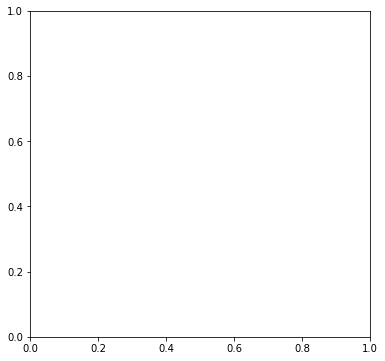

In [10]:
plt.figure(figsize=(28,6.0))
widths = 0.55    
colorsbar = ['red', 'cyan']
plt.subplot(1, 4, 1) 

popRates = []
popNames = []
for number,popName in enumerate(popNames1):
    if popName in Epops:
        popRates.append(popRates1[number])
        popNames.append(popName)        
ind = np.arange(len(popNames))
plt.barh(ind+0.15,popRates, widths, color=colorsbar[0], label='S1-TH disconnected') 

popRates = []
popNames = []
for number,popName in enumerate(popNames2):
    if popName in Epops:
        popRates.append(popRates2[number])
        popNames.append(popName)        
ind = np.arange(len(popNames))
plt.barh(ind-0.15,popRates, widths, color=colorsbar[1], label='S1-TH connected') 

plt.ylim(12.5,-0.5)
plt.xlabel('F (Hz)', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(ind, popNames, fontsize=14)
plt.legend(loc='upper right', fontsize=12, bbox_to_anchor=(0.95, 1.0))
#----------------------------------------------------------------------------------
plt.subplot(1, 4, 2)  

popRates = []
popNames = []
for number,popName in enumerate(popNames1):
    if popName in Ipops[0:15]:
        popRates.append(popRates1[number])
        popNames.append(popName)        
ind = np.arange(len(popNames))
plt.barh(ind+0.15,popRates, widths, color=colorsbar[0], label='S1-TH disconnected') 

popRates = []
popNames = []
for number,popName in enumerate(popNames2):
    if popName in Ipops[0:15]:
        popRates.append(popRates2[number])
        popNames.append(popName)        
ind = np.arange(len(popNames))
plt.barh(ind-0.15,popRates, widths, color=colorsbar[1], label='S1-TH connected') 
        
plt.ylim(14.5,-0.5)
plt.xlabel('F (Hz)', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(ind, popNames, fontsize=12)
plt.legend(loc='upper right', fontsize=12, bbox_to_anchor=(0.95, 1.0))
#----------------------------------------------------------------------------------
plt.subplot(1, 4, 3)   

popRates = []
popNames = []
for number,popName in enumerate(popNames1):
    if popName in Ipops[15:]:
        popRates.append(popRates1[number])
        popNames.append(popName)        
ind = np.arange(len(popNames))
plt.barh(ind+0.15,popRates, widths, color=colorsbar[0], label='S1-TH disconnected') 

popRates = []
popNames = []
for number,popName in enumerate(popNames2):
    if popName in Ipops[15:]:
        popRates.append(popRates2[number])
        popNames.append(popName)        
ind = np.arange(len(popNames))
plt.barh(ind-0.15,popRates, widths, color=colorsbar[1], label='S1-TH connected') 
        
plt.ylim(26.5,-0.5)
plt.xlabel('F (Hz)', fontsize=20)
plt.yticks(ind, popNames, fontsize=11)
plt.xticks(fontsize=14)
plt.legend(loc='upper right', fontsize=12, bbox_to_anchor=(1.005, 1.005))
#----------------------------------------------------------------------------------
plt.subplot(1, 4, 4)   

popRates = []
popNames = []
for number,popName in enumerate(popNames1):
    if popName in thalamicpops:
        popRates.append(popRates1[number])
        
popNames = ['RTN_o', 'RTN_m', 'RTN_i', 'VPL', 'VPM', 'POm']
ind = np.arange(len(popNames))
plt.barh(ind+0.15,popRates, widths, color=colorsbar[0], label='S1-TH disconnected') 

popRates = []
popNames = []
for number,popName in enumerate(popNames2):
    if popName in thalamicpops:
        popRates.append(popRates2[number])
        
popNames = ['RTN_o', 'RTN_m', 'RTN_i', 'VPL', 'VPM', 'POm']
ind = np.arange(len(popNames))
plt.barh(ind-0.15,popRates, widths, color=colorsbar[1], label='S1-TH connected')

plt.ylim(5.5,-0.5)
plt.xlabel('F (Hz)', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(ind, popNames, fontsize=14)
plt.legend(loc='upper right', fontsize=12, bbox_to_anchor=(0.99, 0.2))

namefig = 'S1_Thalamus6.png'
plt.savefig(namefig, facecolor = 'white', bbox_inches='tight' , dpi=300)

# Spontaneous

In [11]:
printVt = ['L23_LBC','L23_NBC','L4_DBC','L4_NGC','L4_PC','L4_SS','L5_MC','L5_STPC','L5_TTPC2','L6_MC','L6_TPC_L4','L6_UTPC','ss_RTN_i','POm_sTC_s1']
printVt = ['ss_RTN_o','ss_RTN_m','ss_RTN_i','VPL_sTC','VPM_sTC','POm_sTC_s1']

# ['L1_DAC','L1_DLAC','L1_HAC','L1_NGC-DA','L1_NGC-SA','L1_SLAC','L23_BP','L23_BTC','L23_ChC','L23_DBC','L23_LBC','L23_MC','L23_NBC','L23_NGC','L23_PC'
# ,'L23_SBC','L4_BP','L4_BTC','L4_ChC','L4_DBC','L4_LBC','L4_MC','L4_NBC','L4_NGC','L4_PC','L4_SBC','L4_SP','L4_SS',
# 'L5_BP','L5_BTC','L5_ChC','L5_DBC','L5_LBC','L5_MC','L5_NBC','L5_NGC','L5_SBC','L5_STPC','L5_TTPC1','L5_TTPC2','L5_UTPC',
# 'L6_BPC','L6_BP','L6_BTC','L6_ChC','L6_DBC','L6_IPC','L6_LBC','L6_MC','L6_NBC','L6_NGC','L6_SBC','L6_TPC_L1','L6_TPC_L4','L6_UTPC','ss_RTN_o','ss_RTN_m','ss_RTN_i','VPL_sTC','VPM_sTC','POm_sTC_s1'

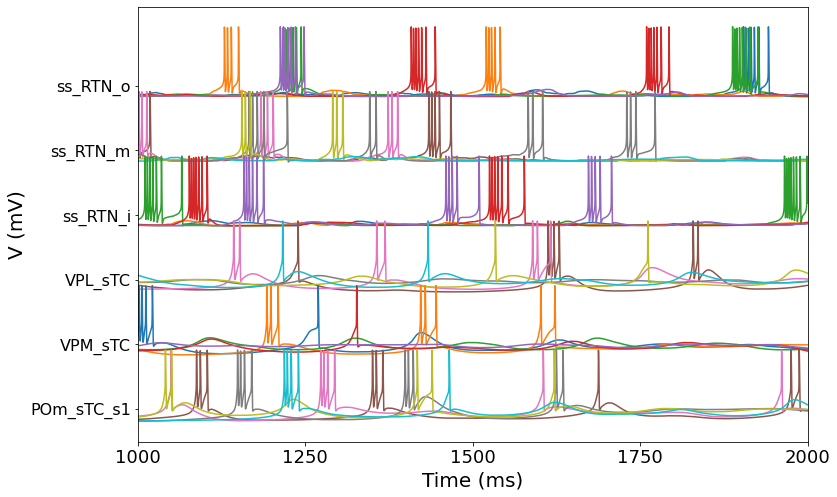

In [24]:
plt.figure(figsize=(12,8)) 
time = np.linspace(0, 5000, 50000)
plt.ylabel('V (mV)', fontsize=20)
plt.xlabel('Time (ms)', fontsize=20)
plt.xlim(170, 2670)
# plt.ylim(-80, -30)
# plt.ylim(-7390+6*120,20)
popinvert = printVt[::-1]
plt.yticks(np.arange(-7260+55*120,60,120),popinvert[0:6], fontsize=16)
plt.xticks(np.arange(170,2671,500),np.arange(0,2501,500),fontsize=18)
plt.xticks(np.arange(1000,2001,250),np.arange(1000,2001,250),fontsize=18)
plt.xlim(1000, 2000)

paramsName = paramsNameList[0]
number = 0
i2 = 0
for i,popName in enumerate(popParam[0:61]):     
    
    for metype in popLabelEl[popName]:
        
        if cellNumber[metype] < 5:
            numberME = cellNumber[metype]
        else:
            numberME = 5
            
        for j in range(numberME):    
            if popName in printVt:
                Vt = np.array(data[paramsName]['V_soma']['cell_'+str(cellVNumber[number])])
                plt.plot(time, (Vt-i2*120.0)) 
            number = number + 1

    if popName in printVt:
        i2+=1
plt.savefig('Vt_zoom_spontaneus_' + paramsName + '.png', facecolor = 'white', bbox_inches='tight' , dpi=300)

# S1_Thalamus

In [163]:
printVt = ['L1_NGC-DA','L1_SLAC','L23_LBC','L23_MC','L23_NGC','L4_DBC','L4_MC','L4_NGC','L4_SS','L4_SP','L5_MC','L5_TTPC1','L5_TTPC2','L5_UTPC','L6_IPC','L6_MC','L6_TPC_L1','L6_TPC_L4','L6_UTPC','VPL_sTC','VPM_sTC','POm_sTC_s1']
# ['L1_DAC','L1_DLAC','L1_HAC','L1_NGC-DA','L1_NGC-SA','L1_SLAC','L23_BP','L23_BTC','L23_ChC','L23_DBC','L23_LBC','L23_MC','L23_NBC','L23_NGC','L23_PC'
# ,'L23_SBC','L4_BP','L4_BTC','L4_ChC','L4_DBC','L4_LBC','L4_MC','L4_NBC','L4_NGC','L4_PC','L4_SBC','L4_SP','L4_SS',
# 'L5_BP','L5_BTC','L5_ChC','L5_DBC','L5_LBC','L5_MC','L5_NBC','L5_NGC','L5_SBC','L5_STPC','L5_TTPC1','L5_TTPC2','L5_UTPC',
# 'L6_BPC','L6_BP','L6_BTC','L6_ChC','L6_DBC','L6_IPC','L6_LBC','L6_MC','L6_NBC','L6_NGC','L6_SBC','L6_TPC_L1','L6_TPC_L4','L6_UTPC','ss_RTN_o','ss_RTN_m','ss_RTN_i','VPL_sTC','VPM_sTC','POm_sTC_s1'

In [190]:
# plt.figure(figsize=(13,15)) 
# time = np.linspace(0, 5000, 50000)
# plt.ylabel('V (mV)', fontsize=20)
# plt.xlabel('Time (ms)', fontsize=20)
# plt.xlim(620, 1420)
# # plt.ylim(-80, -30)
# # plt.ylim(-7390+6*120,20)
# popinvert = printVt[::-1]
# plt.yticks(np.arange(-7260+39*120,60,120),popinvert[0:25], fontsize=16)
# plt.xticks(np.arange(620,1430,200),np.arange(400,1210,200),fontsize=18)

# paramsName = paramsNameList[1]
# number = 0
# i2 = 0
# for i,popName in enumerate(popParam[0:61]):     
    
#     for metype in popLabelEl[popName]:
        
#         if cellNumber[metype] < 5:
#             numberME = cellNumber[metype]
#         else:
#             numberME = 5
            
#         for j in range(numberME):    
#             if popName in printVt:
#                 Vt = np.array(data[paramsName]['V_soma']['cell_'+str(cellVNumber[number])])
#                 plt.plot(time, (Vt-i2*120.0)) 
#             number = number + 1

#     if popName in printVt:
#         i2+=1
# plt.savefig('Vt_zoom_' + paramsName + '.png', facecolor = 'white', bbox_inches='tight' , dpi=300)

In [182]:
printVt = ['L1_DAC','L1_DLAC','L1_HAC','L1_NGC-DA','L1_NGC-SA','L1_SLAC','L23_BP','L23_BTC','L23_ChC','L23_DBC','L23_LBC','L23_MC','L23_NBC','L23_NGC','L23_PC'
,'L23_SBC','L4_BP','L4_BTC','L4_ChC','L4_DBC','L4_LBC','L4_MC','L4_NBC','L4_NGC','L4_PC','L4_SBC','L4_SP','L4_SS',
'L5_BP','L5_BTC','L5_ChC','L5_DBC','L5_LBC','L5_MC','L5_NBC','L5_NGC','L5_SBC','L5_STPC','L5_TTPC1','L5_TTPC2','L5_UTPC',
'L6_BPC','L6_BP','L6_BTC','L6_ChC','L6_DBC','L6_IPC','L6_LBC','L6_MC','L6_NBC','L6_NGC','L6_SBC','L6_TPC_L1','L6_TPC_L4','L6_UTPC','ss_RTN_o',
           'ss_RTN_m','ss_RTN_i','VPL_sTC','VPM_sTC','POm_sTC_s1']

In [189]:
# plt.figure(figsize=(18,32)) 
# time = np.linspace(0, 5000, 50000)
# plt.ylabel('V (mV)', fontsize=20)
# plt.xlabel('Time (ms)', fontsize=20)
# plt.xlim(620, 1420)
# # plt.ylim(-80, -30)
# # plt.ylim(-7390+6*120,20)
# popinvert = printVt[::-1]
# plt.yticks(np.arange(-7260+0*120,60,120),popinvert[0:61], fontsize=18)
# plt.xticks(np.arange(620,1430,200),np.arange(400,1210,200),fontsize=18)

# paramsName = paramsNameList[1]
# number = 0
# i2 = 0
# for i,popName in enumerate(popParam[0:61]):   
#     for metype in popLabelEl[popName]:
        
#         if cellNumber[metype] < 5:
#             numberME = cellNumber[metype]
#         else:
#             numberME = 5
            
#         for j in range(numberME):    
#             Vt = np.array(data[paramsName]['V_soma']['cell_'+str(cellVNumber[number])])
#             plt.plot(time, (Vt-i*120.0)) 
#             number = number + 1

# plt.savefig('Vt_after-transient_' + paramsName + '.png', facecolor = 'white', bbox_inches='tight' , dpi=300)

In [188]:
# plt.figure(figsize=(18,24)) 
# time = np.linspace(0, 5000, 50000)
# plt.ylabel('V (mV)', fontsize=16)
# plt.xlabel('time (ms)', fontsize=16)
# plt.xlim(1680, 1780)
# # plt.ylim(-80, -30)
# plt.ylim(-7390+6*120,20)
# popinvert = popParam[::-1]
# plt.yticks(np.arange(-7260+6*120,60,120),popinvert[6:61], fontsize=14)
# plt.xticks(fontsize=14)

# paramsName = paramsNameList[0]
# number = 0
# for i,popName in enumerate(popParam[0:55]):   
#     for metype in popLabelEl[popName]:
        
#         if cellNumber[metype] < 5:
#             numberME = cellNumber[metype]
#         else:
#             numberME = 5
            
#         for j in range(numberME):    
#             Vt = np.array(data[paramsName]['V_soma']['cell_'+str(cellVNumber[number])])
#             if popName in Epops:
#                 plt.plot(time, (Vt-i*120.0),'r') 
#             else:
#                 plt.plot(time, (Vt-i*120.0),'c') 
#             number = number + 1

# plt.savefig('Vt_after-transient_' + paramsName + '.png', facecolor = 'white', bbox_inches='tight' , dpi=300)

In [187]:
# plt.figure(figsize=(24,5)) 

# plt.ylabel('L6', fontsize=32)
# plt.xlabel('time (ms)', fontsize=32)
# plt.xlim(1680, 1770)
# plt.ylim(31346, 18632)
# plt.yticks([18632,31346], fontsize=32)
# plt.xticks([1700,1750],[1700,1750],fontsize=32)
# plt.plot(data[paramsName]['spkt'],data[paramsName]['spkid'], 'r.')



# plt.savefig('Raster_zoom_L6_' + paramsName + '.png', facecolor = 'white', bbox_inches='tight' , dpi=300)

In [186]:
# plt.figure(figsize=(36,24)) 
# time = np.linspace(0, 5000, 50000)
# plt.ylabel('V (mV)', fontsize=16)
# plt.xlabel('time (ms)', fontsize=16)
# plt.xlim(0, 5000)
# # plt.ylim(-80, -30)
# plt.ylim(-7390+6*120,20)
# popinvert = popParam[::-1]
# plt.yticks(np.arange(-7260+6*120,60,120),popinvert[6:61], fontsize=14)
# plt.xticks(fontsize=14)

# paramsName = paramsNameList[1]
# number = 0
# i2 = 0
# for i,popName in enumerate(popParam[0:55]):   
#     for metype in popLabelEl[popName]:
        
#         if cellNumber[metype] < 5:
#             numberME = cellNumber[metype]
#         else:
#             numberME = 5
            
#         for j in range(numberME):    
#             Vt = np.array(data[paramsName]['V_soma']['cell_'+str(cellVNumber[number])])
#             plt.plot(time, (Vt-i*120.0)) 
#             number = number + 1

# plt.savefig('Vt_after-transient_' + paramsName + '.png', facecolor = 'white', bbox_inches='tight' , dpi=300)